In [48]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             accuracy_score)
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)

from tensorflow.keras import layers, models, regularizers

In [25]:
## Here we will define several helper functions to compute these metrics 
# This is just a helper function to get the smape metric - no need to change 
def smape(A, F):
    out =  100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return(out)

def RegmodelPerformance(y_true, y_pred):
    exp_var = metrics.explained_variance_score(y_true, y_pred)
    r_square = metrics.r2_score(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    MAE = metrics.mean_absolute_error(y_true, y_pred)
    SMAPE = smape(np.array(y_true), y_pred)
    return(exp_var, r_square, MSE, MAE, SMAPE)

def regression_plot(y_true, y_pred):
        # Calculate R^2 value
    r2 = metrics.r2_score(y_true, y_pred) 

    # Plotting
    plt.scatter(y_true, y_pred)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', label='perfect model')
    plt.title(f'Actual vs. Predicted with R^2 = {r2:.2f}')
    plt.xlabel('Actual Severity')
    plt.ylabel('Predicted Severity')
    plt.legend()
    plt.show()

def printPerformance(y_true, y_pred):
    exp_var, r_square, MSE, MAE, SMAPE = RegmodelPerformance(y_true, y_pred)
    print("explained variance score = " "%.4f" % exp_var)
    print("R2 = " "%.4f" % r_square)
    print("MSE = " "%.4f" % MSE)
    print("MAE = " "%.4f" % MAE)
    print("SMAPE = " "%.4f" % SMAPE)
    np.set_printoptions(precision=2)
    regression_plot(y_true, y_pred)
    metric = np.array([exp_var, r_square, MSE, MAE, SMAPE])
    return(metric)

In [13]:
vgg19_feature_severity = pd.read_csv('vgg19_feature_severity.csv')
merged_df = pd.read_csv('paired_image_severity.csv')
display(merged_df.head(3))
display(vgg19_feature_severity.head(3))
vgg19_feature_list = np.array(vgg19_feature_severity.iloc[:, 3:12804])
print(vgg19_feature_list.shape)
vgg19_feature_list

,Unnamed: 0.1,Unnamed: 0,ImageA,ImageB,SeverityA,SeverityB,SeverityB - SeverityA,Progression
0,0,0,0,510,10,11,1,Worsened
1,1,1,1,169,10,9,-1,Improved
2,2,2,1,16,10,12,2,Worsened


,Unnamed: 0,id,severity,0,1,2,3,4,5,6,...,12790,12791,12792,12793,12794,12795,12796,12797,12798,12799
0,0,dermnet/train/Psoriasis pictures Lichen Planus...,10,4.267727,0.0,0.0,0.000000,0.0000,0.0,0.00000,...,0.000000,0.0,4.790735,54.445866,0.000000,0.0,0.000000,0.0,21.140205,0.0
1,1,dermnet/train/Psoriasis pictures Lichen Planus...,10,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.00000,...,0.000000,0.0,8.161653,7.837052,10.883604,0.0,0.000000,0.0,0.000000,0.0
2,2,dermnet/train/Psoriasis pictures Lichen Planus...,5,0.000000,0.0,0.0,16.705368,12.6071,0.0,2.40042,...,25.521635,0.0,0.000000,10.020402,0.000000,0.0,36.357765,0.0,2.955516,0.0


(511, 12800)


array([[ 4.267727 ,  0.       ,  0.       , ...,  0.       , 21.140205 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  2.955516 ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  1.5029893,
         0.       ],
       [ 4.267727 ,  0.       ,  0.       , ...,  0.       , 21.140203 ,
         0.       ]])

In [14]:
# Extract feature vectors for ImageA and ImageB
feature_vectors_A = vgg19_feature_list[merged_df['ImageA'].values]
feature_vectors_B = vgg19_feature_list[merged_df['ImageB'].values]

# Prepare pairs of feature vectors
X_pairs_A = feature_vectors_A
X_pairs_B = feature_vectors_B

# Compute severity differences
y_differences = merged_df['SeverityB - SeverityA'].values

# Display the prepared data
print("Feature Vectors A Shape:", X_pairs_A.shape)
print("Feature Vectors B Shape:", X_pairs_B.shape)
print("Severity Differences Shape:", y_differences.shape)

Feature Vectors A Shape: (424, 12800)
Feature Vectors B Shape: (424, 12800)
Severity Differences Shape: (424,)


In [52]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_siamese_network(input_shape):
    # Input layers for the two branches
    input_layer1 = layers.Input(shape=input_shape)
    input_layer2 = layers.Input(shape=input_shape)

    # Feature scaling using BatchNormalization
    batch_norm_layer1 = layers.BatchNormalization()(input_layer1)
    batch_norm_layer2 = layers.BatchNormalization()(input_layer2)
    
    # Shared subnetwork
    shared_subnetwork = models.Sequential([
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu')
    ])

    shared_subnetwork = models.Sequential([
        layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l1(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
    ])

    # Branches of the siamese network
    branch1 = shared_subnetwork(batch_norm_layer1)
    branch2 = shared_subnetwork(batch_norm_layer2)

    # Absolute difference layer
    absolute_difference = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([branch1, branch2])

    # Regression output
    output_layer = layers.Dense(1, activation='linear')(absolute_difference)

    model = models.Model(inputs=[input_layer1, input_layer2], outputs=output_layer)
    return model

# Sample usage
input_shape = (vgg19_feature_list.shape[1],)  # Adjust the size based on your feature vectors
siamese_model = create_siamese_network(input_shape)
siamese_model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
# Assuming you have already prepared X_pairs_A, X_pairs_B, and y_differences as described in the previous code

CID = 0
epochs = 10
batch_size = 16

# Train-test split (you can customize this based on your dataset)
X_train_pairs_A, X_test_pairs_A, X_train_pairs_B, X_test_pairs_B, y_train_difference, y_test_difference = train_test_split(
    X_pairs_A, X_pairs_B, y_differences, test_size=0.2, random_state=CID
)

# Train the model
siamese_model.fit([X_train_pairs_A, X_train_pairs_B], y_train_difference, epochs=epochs, batch_size=batch_size)

# Evaluate the model
loss = siamese_model.evaluate([X_test_pairs_A, X_test_pairs_B], y_test_difference)
print("Test Loss:", loss)


Epoch 1/10
22/22 [==============================] - 1s 30ms/step - loss: 130.0817
Epoch 2/10
22/22 [==============================] - 1s 31ms/step - loss: 132.0038
Epoch 3/10
22/22 [==============================] - 1s 30ms/step - loss: 132.8480
Epoch 4/10
22/22 [==============================] - 1s 29ms/step - loss: 133.3055
Epoch 5/10
22/22 [==============================] - 1s 29ms/step - loss: 131.5634
Epoch 6/10
22/22 [==============================] - 1s 29ms/step - loss: 131.3800
Epoch 7/10
22/22 [==============================] - 1s 29ms/step - loss: 129.1521
Epoch 8/10
22/22 [==============================] - 1s 29ms/step - loss: 128.7617
Epoch 9/10
22/22 [==============================] - 1s 29ms/step - loss: 127.2960
Epoch 10/10
3/3 [==============================] - 0s 10ms/step - loss: 130.4051
Test Loss: 130.40512084960938


3/3 [==============================] - 0s 7ms/step
explained variance score = -0.1060
R2 = -0.1547
MSE = 12.1075
MAE = 2.7513
SMAPE = 14399.2690


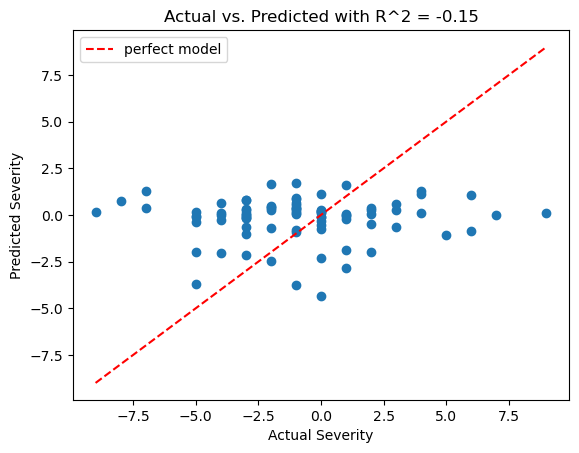

array([-1.06e-01, -1.55e-01,  1.21e+01,  2.75e+00,  1.44e+04])

In [56]:
y_pred = siamese_model.predict([X_test_pairs_A, X_test_pairs_B])
printPerformance(y_test_difference, y_pred)

explained variance score = 0.0033
R2 = -0.0760
MSE = 11.2820
MAE = 2.5733
SMAPE = 16829.9806


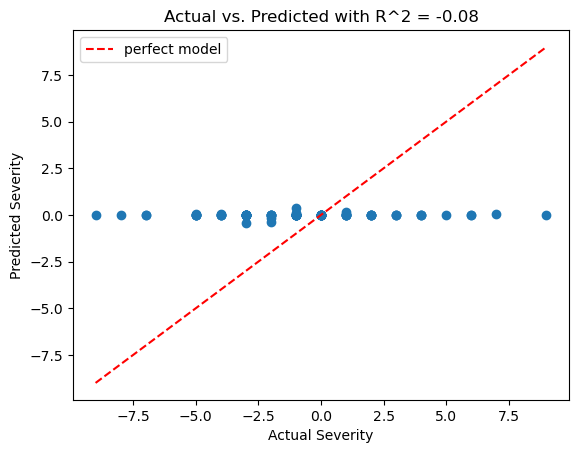

array([ 3.35e-03, -7.60e-02,  1.13e+01,  2.57e+00,  1.68e+04])

# Try EfficientNet

In [57]:
pip install tensorflow efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


pip install tensorflow efficientnet


In [90]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Concatenate,Dense
from tensorflow.keras.optimizers.legacy import Adam
from efficientnet.tfkeras import EfficientNetB0



In [59]:
display(merged_df.head(3))
display(vgg19_feature_severity.head(3))

,Unnamed: 0.1,Unnamed: 0,ImageA,ImageB,SeverityA,SeverityB,SeverityB - SeverityA,Progression
0,0,0,0,510,10,11,1,Worsened
1,1,1,1,169,10,9,-1,Improved
2,2,2,1,16,10,12,2,Worsened


,Unnamed: 0,id,severity,0,1,2,3,4,5,6,...,12790,12791,12792,12793,12794,12795,12796,12797,12798,12799
0,0,dermnet/train/Psoriasis pictures Lichen Planus...,10,4.267727,0.0,0.0,0.000000,0.0000,0.0,0.00000,...,0.000000,0.0,4.790735,54.445866,0.000000,0.0,0.000000,0.0,21.140205,0.0
1,1,dermnet/train/Psoriasis pictures Lichen Planus...,10,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.00000,...,0.000000,0.0,8.161653,7.837052,10.883604,0.0,0.000000,0.0,0.000000,0.0
2,2,dermnet/train/Psoriasis pictures Lichen Planus...,5,0.000000,0.0,0.0,16.705368,12.6071,0.0,2.40042,...,25.521635,0.0,0.000000,10.020402,0.000000,0.0,36.357765,0.0,2.955516,0.0


In [182]:
import pandas as pd
from PIL import Image
import os

# Function to load images based on indices and directories
def load_images(df_pairs, df_image_info):
    loaded_images = []
    for index, row in df_pairs.iterrows():
        image_a_index = row['ImageA']
        image_b_index = row['ImageB']

        image_a_path = df_image_info.loc[image_a_index, 'id']
        image_b_path = df_image_info.loc[image_b_index, 'id']

        image_a = Image.open(image_a_path)
        image_b = Image.open(image_b_path)

        loaded_images.append((image_a, image_b))

    return loaded_images

# Example usage
loaded_images = load_images(merged_df, vgg19_feature_severity)


In [92]:
# Assuming you have already prepared X_pairs_A, X_pairs_B, and y_differences as described in the previous code
CID = 0

In [179]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Assume input shape for EfficientNet is (224, 224, 3)
input_shape = (224, 224, 3)

# Create a custom data generator with data augmentation
class SiameseDataGenerator(Sequence):
    def __init__(self, loaded_images, labels, batch_size=32, augment=True, shuffle=True):
        self.loaded_images = loaded_images
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(loaded_images))
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.loaded_images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.loaded_images[start:end]
        batch_labels = self.labels[start:end]
        return self.__data_generation(batch_images, batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_images, batch_labels):
        X1 = []
        X2 = []

        for image_pair in batch_images:
            image_a, image_b = image_pair

            image_a = img_to_array(image_a.resize((input_shape[0], input_shape[1])))
            image_b = img_to_array(image_b.resize((input_shape[0], input_shape[1])))

            # Apply data augmentation if specified
            if self.augment:

                # Apply data augmentation to the entire 3D array
                augmented_image_a = self.datagen.random_transform(image_a)
                augmented_image_b = self.datagen.random_transform(image_b)

                image_a = augmented_image_a
                image_b = augmented_image_b

            # Preprocess images for EfficientNet
            image_a = preprocess_input(image_a)
            image_b = preprocess_input(image_b)

            X1.append(image_a)
            X2.append(image_b)

        return [np.array(X1), np.array(X2)], np.array(batch_labels)

def create_efficientnet_siamese_network(input_shape):
    # Create EfficientNet base model (you need to import the efficientnet model from tensorflow.keras.applications)
    efficientnet_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the layers of the base model
    for layer in efficientnet_model.layers:
        layer.trainable = True

    # Create input tensors
    input_a = Input(shape=input_shape, name='input_a')
    input_b = Input(shape=input_shape, name='input_b')

    # Get the embeddings from the base model for both inputs
    embedding_a = efficientnet_model(input_a)
    embedding_b = efficientnet_model(input_b)

    # Global Average Pooling to reduce spatial dimensions
    embedding_a = GlobalAveragePooling2D()(embedding_a)
    embedding_b = GlobalAveragePooling2D()(embedding_b)

    # Concatenate the embeddings
    concatenated_embeddings = Concatenate()([embedding_a, embedding_b])

    # Add Dense layers with dropout
    x = Dense(1024, activation='relu')(concatenated_embeddings)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    # Dense layer for final prediction
    prediction = Dense(1, activation='linear')(x)

    # Create the Siamese model
    siamese_model = Model(inputs=[input_a, input_b], outputs=prediction)

    return siamese_model

# Compile the Siamese model with Mean Squared Error (MSE) loss
siamese_model = create_efficientnet_siamese_network(input_shape)
siamese_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Assuming 'SeverityB - SeverityA' column in df_pairs contains the severity differences
labels = merged_df['SeverityB - SeverityA'].values

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(loaded_images, labels, test_size=0.2, random_state=CID)

# Create data generators for training and testing
batch_size = 8
train_data_generator = SiameseDataGenerator(train_images, train_labels, batch_size=batch_size, augment=True)
test_data_generator = SiameseDataGenerator(test_images, test_labels, batch_size=batch_size)

siamese_model = create_efficientnet_siamese_network(input_shape)

# Set the learning rate
learning_rate = 0.00001  # You can adjust this value

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

siamese_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the Siamese network with ModelCheckpoint callback for saving the best model
checkpoint_filepath = 'siamese_model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the Siamese network
history = siamese_model.fit(train_data_generator, epochs=20, validation_data=test_data_generator, callbacks=[model_checkpoint])

# Save the entire model
siamese_model.save('siamese_model.h5')

# Save the training history
import pickle

with open('siamese_model_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)



Epoch 1/20
43/43 [==============================] - ETA: 0s - loss: 9.0643
Epoch 1: val_loss improved from inf to 11.34923, saving model to siamese_model_checkpoint.h5
43/43 [==============================] - 23s 433ms/step - loss: 9.0643 - val_loss: 11.3492
Epoch 2/20
43/43 [==============================] - ETA: 0s - loss: 9.0233
Epoch 2: val_loss did not improve from 11.34923
43/43 [==============================] - 18s 405ms/step - loss: 9.0233 - val_loss: 11.3659
Epoch 3/20
43/43 [==============================] - ETA: 0s - loss: 8.8993
Epoch 3: val_loss did not improve from 11.34923
43/43 [==============================] - 17s 395ms/step - loss: 8.8993 - val_loss: 11.3513
Epoch 4/20
43/43 [==============================] - ETA: 0s - loss: 9.1340
Epoch 4: val_loss did not improve from 11.34923
43/43 [==============================] - 17s 391ms/step - loss: 9.1340 - val_loss: 11.3575
Epoch 5/20
43/43 [==============================] - ETA: 0s - loss: 9.0260
Epoch 5: val_loss improv

In [165]:
# Evaluate the model on the test set
evaluation_result = siamese_model.evaluate(test_data_generator)

print(f"Mean Squared Error on Test Set: {evaluation_result}")

11/11 [==============================] - 1s 123ms/step - loss: 9.6638
Mean Squared Error on Test Set: 9.663844108581543


In [180]:
# Predict on the test set
predictions = siamese_model.predict(test_data_generator)
printPerformance(test_labels, predictions)

11/11 [==============================] - 2s 129ms/step


TypeError: printPerformance() takes 1 positional argument but 2 were given

In [174]:
def conf_matrix_heatmap(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Greens'); #annot=True to annotate cells
    ax.set_xlabel('Predicted status')
    ax.set_ylabel('True status')
    ax.set_title('Confusion Matrix')

def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    np.set_printoptions(precision=2)
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)

In [175]:
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report

              precision    recall  f1-score   support

    Improved       0.72      0.63      0.67        49
   No change       0.18      0.23      0.20        13
    Worsened       0.36      0.39      0.37        23

    accuracy                           0.51        85
   macro avg       0.42      0.42      0.42        85
weighted avg       0.54      0.51      0.52        85

accuracy: 0.5058823529411764


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

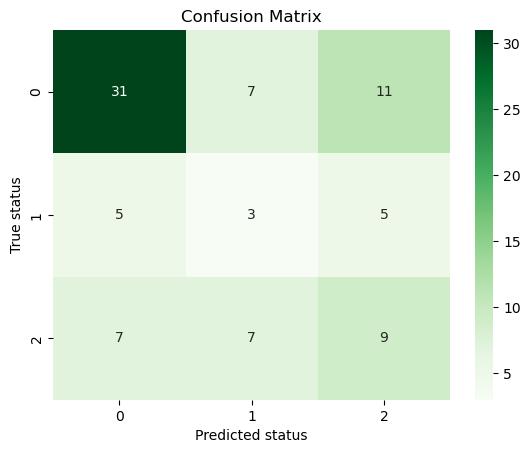

In [176]:
# Convert Enet result to 3 classes
# Function to categorize values
def categorize_value(value):
    if value > 0.5:
        return 'Worsened'
    elif value < -0.5:
        return 'Improved'
    else:
        return 'No change'

# Apply the function to create a new categorical column
predictions = np.vectorize(categorize_value)(predictions)
test_labels_cat = np.vectorize(categorize_value)(test_labels)


print(classification_report(test_labels_cat, predictions))
print('accuracy:', accuracy_score(test_labels_cat, predictions))

cm_default = confusion_matrix(test_labels_cat, predictions)
conf_matrix_heatmap(cm_default)
display(test_labels_cat.value_counts()) # to see the class breakdown in the test-set 

In [183]:
from tensorflow.keras.applications import ResNet101

def create_resnet_siamese_network(input_shape):
    # Create EfficientNet base model (you need to import the efficientnet model from tensorflow.keras.applications)
    resnet_model = ResNet101(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the layers of the base model
    for layer in resnet_model.layers:
        layer.trainable = True

    # Create input tensors
    input_a = Input(shape=input_shape, name='input_a')
    input_b = Input(shape=input_shape, name='input_b')

    # Get the embeddings from the base model for both inputs
    embedding_a = resnet_model(input_a)
    embedding_b = resnet_model(input_b)

    # Global Average Pooling to reduce spatial dimensions
    embedding_a = GlobalAveragePooling2D()(embedding_a)
    embedding_b = GlobalAveragePooling2D()(embedding_b)

    # Concatenate the embeddings
    concatenated_embeddings = Concatenate()([embedding_a, embedding_b])

    # Add Dense layers with dropout
    x = Dense(1024, activation='relu')(concatenated_embeddings)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)

    # Dense layer for final prediction
    prediction = Dense(1, activation='linear')(x)

    # Create the Siamese model
    siamese_model = Model(inputs=[input_a, input_b], outputs=prediction)

    return siamese_model

In [184]:



# Assuming 'SeverityB - SeverityA' column in df_pairs contains the severity differences
labels = merged_df['SeverityB - SeverityA'].values

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(loaded_images, labels, test_size=0.2, random_state=CID)

# Create data generators for training and testing
batch_size = 8
train_data_generator = SiameseDataGenerator(train_images, train_labels, batch_size=batch_size, augment=True)
test_data_generator = SiameseDataGenerator(test_images, test_labels, batch_size=batch_size)

# Set the learning rate
learning_rate = 0.00001  # You can adjust this value

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

siamese_model = create_resnet_siamese_network(input_shape)
siamese_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the Siamese network with ModelCheckpoint callback for saving the best model
checkpoint_filepath = 'siamese_resnet_checkpoint.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the Siamese network
history = siamese_model.fit(train_data_generator, epochs=20, validation_data=test_data_generator, callbacks=[model_checkpoint])

# Save the entire model
siamese_model.save('siamese_resnet.h5')


# Save the training history
import pickle

with open('siamese_resnet_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

171446536/171446536 [==============================] - 21s 0us/step
Epoch 1/20
43/43 [==============================] - ETA: 0s - loss: 9.1908
Epoch 1: val_loss improved from inf to 11.35936, saving model to siamese_resnet_checkpoint.h5


/Users/kexinxu/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 85s 2s/step - loss: 9.1908 - val_loss: 11.3594
Epoch 2/20
43/43 [==============================] - ETA: 0s - loss: 9.3230
Epoch 2: val_loss improved from 11.35936 to 11.34349, saving model to siamese_resnet_checkpoint.h5
43/43 [==============================] - 81s 2s/step - loss: 9.3230 - val_loss: 11.3435
Epoch 3/20
43/43 [==============================] - ETA: 0s - loss: 9.5868
Epoch 3: val_loss improved from 11.34349 to 11.31230, saving model to siamese_resnet_checkpoint.h5
43/43 [==============================] - 80s 2s/step - loss: 9.5868 - val_loss: 11.3123
Epoch 4/20
43/43 [==============================] - ETA: 0s - loss: 9.0156
Epoch 4: val_loss did not improve from 11.31230
43/43 [==============================] - 79s 2s/step - loss: 9.0156 - val_loss: 11.3459
Epoch 5/20
43/43 [==============================] - ETA: 0s - loss: 9.0636
Epoch 5: val_loss did not improve from 11.31230
43/43 [==============================] - 79s 2s/step -

In [186]:
siamese_model.fit(train_data_generator, epochs=20, validation_data=test_data_generator, callbacks=[model_checkpoint])

Epoch 1/20
43/43 [==============================] - ETA: 0s - loss: 8.5403
Epoch 1: val_loss did not improve from 11.24402
43/43 [==============================] - 73s 2s/step - loss: 8.5403 - val_loss: 11.2587
Epoch 2/20
43/43 [==============================] - ETA: 0s - loss: 9.0342
Epoch 2: val_loss did not improve from 11.24402
43/43 [==============================] - 70s 2s/step - loss: 9.0342 - val_loss: 11.2707
Epoch 3/20
43/43 [==============================] - ETA: 0s - loss: 8.6754
Epoch 3: val_loss did not improve from 11.24402
43/43 [==============================] - 70s 2s/step - loss: 8.6754 - val_loss: 11.2814
Epoch 4/20
43/43 [==============================] - ETA: 0s - loss: 9.0261
Epoch 4: val_loss did not improve from 11.24402
43/43 [==============================] - 70s 2s/step - loss: 9.0261 - val_loss: 11.2835
Epoch 5/20
43/43 [==============================] - ETA: 0s - loss: 9.1251
Epoch 5: val_loss did not improve from 11.24402
43/43 [==========================

KeyboardInterrupt: 

In [187]:
def create_resnet_siamese_frozen_network(input_shape):
    # Create EfficientNet base model (you need to import the efficientnet model from tensorflow.keras.applications)
    resnet_model = ResNet101(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the layers of the base model
    for layer in resnet_model.layers:
        layer.trainable = False

    # Create input tensors
    input_a = Input(shape=input_shape, name='input_a')
    input_b = Input(shape=input_shape, name='input_b')

    # Get the embeddings from the base model for both inputs
    embedding_a = resnet_model(input_a)
    embedding_b = resnet_model(input_b)

    # Global Average Pooling to reduce spatial dimensions
    embedding_a = GlobalAveragePooling2D()(embedding_a)
    embedding_b = GlobalAveragePooling2D()(embedding_b)

    # Concatenate the embeddings
    concatenated_embeddings = Concatenate()([embedding_a, embedding_b])

    # Add Dense layers with dropout
    x = Dense(1024, activation='relu')(concatenated_embeddings)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)

    # Dense layer for final prediction
    prediction = Dense(1, activation='linear')(x)

    # Create the Siamese model
    siamese_model = Model(inputs=[input_a, input_b], outputs=prediction)

    return siamese_model

In [190]:
resnet_model = ResNet101(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in resnet_model.layers:
    layer.trainable = False

len(resnet_model.layers)

345

In [188]:
def unfreeze_layers(model, num_unfreeze):
    for layer in model.layers[-num_unfreeze:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

initial_epochs = 5
unfreeze_epochs = 20
total_epochs = initial_epochs + unfreeze_epochs

siamese_model_frozen = create_resnet_siamese_frozen_network(input_shape)
siamese_model_frozen.compile(optimizer=optimizer, loss='mean_squared_error')


# Initial training with frozen layers
siamese_model_frozen.fit(train_data_generator, epochs=20, validation_data=test_data_generator)




Epoch 1/20
43/43 [==============================] - 27s 565ms/step - loss: 15.9019 - val_loss: 11.5425
Epoch 2/20
43/43 [==============================] - 23s 536ms/step - loss: 12.8294 - val_loss: 11.3944
Epoch 3/20
43/43 [==============================] - 23s 532ms/step - loss: 11.5061 - val_loss: 11.3905
Epoch 4/20
43/43 [==============================] - 23s 534ms/step - loss: 10.3836 - val_loss: 11.5089
Epoch 5/20
43/43 [==============================] - 23s 533ms/step - loss: 9.9234 - val_loss: 11.4848
Epoch 6/20
43/43 [==============================] - 23s 533ms/step - loss: 11.1982 - val_loss: 11.4779
Epoch 7/20
43/43 [==============================] - 23s 533ms/step - loss: 10.9921 - val_loss: 11.4222
Epoch 8/20
43/43 [==============================] - 23s 533ms/step - loss: 9.9932 - val_loss: 11.4286
Epoch 9/20
43/43 [==============================] - 23s 533ms/step - loss: 10.9903 - val_loss: 11.3920
Epoch 10/20
43/43 [==============================] - 23s 533ms/step - loss:

NameError: name 'resnet_model' is not defined

In [193]:
initial_epochs = 0
unfreeze_epochs = 30
total_epochs = initial_epochs + unfreeze_epochs


# Gradual unfreezing and fine-tuning
for i in range(1, unfreeze_epochs):
    num_unfreeze = i * (len(resnet_model.layers) // unfreeze_epochs)
    unfreeze_layers(siamese_model_frozen, num_unfreeze)

    siamese_model_frozen.compile(optimizer=optimizer, loss='mean_squared_error')
    siamese_model_frozen.fit(train_data_generator, epochs=1, validation_data=test_data_generator)

# Save the entire model


43/43 [==============================] - 76s 2s/step - loss: 8.5229 - val_loss: 11.2598


In [ ]:
initial_epochs = 0
unfreeze_epochs = 20
total_epochs = initial_epochs + unfreeze_epochs


# Gradual unfreezing and fine-tuning
for i in range(1, unfreeze_epochs):
    num_unfreeze = i * (len(resnet_model.layers) // unfreeze_epochs)
    unfreeze_layers(siamese_model_frozen, num_unfreeze)

    siamese_model_frozen.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    siamese_model_frozen.fit(train_data_generator, epochs=1, validation_data=test_data_generator)